In [5]:
from pre_processing import load_and_clean_data
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = load_and_clean_data(
    "diabetes_prediction_dataset.csv", split=True, standardize= True
)

In [6]:
# Create the pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression())
])

In [9]:
# Update param grid with correct prefix for pipeline
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga'],
    'clf__class_weight': ['balanced'],
    'clf__max_iter': [500, 1000]
}
f1_minority = make_scorer(f1_score, pos_label=1)
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

In [10]:
# GridSearch with pipeline
grid = GridSearchCV(pipeline, param_grid, scoring=f1_minority, cv=cv, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': ['balanced'],
                         'clf__max_iter': [500, 1000],
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['liblinear', 'saga']},
             scoring=make_scorer(f1_score, pos_label=1))

In [11]:
print("Best params:", grid.best_params_)
print("Best F1 (CV minority):", grid.best_score_)

Best params: {'clf__C': 0.001, 'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best F1 (CV minority): 0.5814277031470637


In [12]:
best_model = grid.best_estimator_
y_val_pred = best_model.predict(X_val)
y_val_proba = best_model.predict_proba(X_val)[:, 1]

In [13]:
print("\nClassification Report on Validation Set:\n")
print(classification_report(y_val, y_val_pred, digits=4))


Classification Report on Validation Set:

              precision    recall  f1-score   support

           0     0.9869    0.8916    0.9368      8767
           1     0.4392    0.8774    0.5854       848

    accuracy                         0.8904      9615
   macro avg     0.7130    0.8845    0.7611      9615
weighted avg     0.9386    0.8904    0.9058      9615



In [14]:
# Threshold tuning
for t in [0.3, 0.4, 0.5, 0.6]:
    y_pred_thresh = (y_val_proba >= t).astype(int)
    print(f"\nThreshold: {t}")
    print(classification_report(y_val, y_pred_thresh))


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.99      0.77      0.87      8767
           1       0.29      0.96      0.45       848

    accuracy                           0.79      9615
   macro avg       0.64      0.87      0.66      9615
weighted avg       0.93      0.79      0.83      9615


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      8767
           1       0.36      0.93      0.52       848

    accuracy                           0.85      9615
   macro avg       0.68      0.88      0.71      9615
weighted avg       0.94      0.85      0.88      9615


Threshold: 0.5
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      8767
           1       0.44      0.88      0.59       848

    accuracy                           0.89      9615
   macro avg       0.71      0.88      0.76      9615
weighted avg       0.94   

In [15]:
# Final threshold 
y_val_proba = best_model.predict_proba(X_val)[:, 1]
custom_threshold = 0.6
y_val_pred_custom = (y_val_proba >= custom_threshold).astype(int)
print(f"\nClassification Report (Threshold = {custom_threshold}):")
print(classification_report(y_val, y_val_pred_custom))


Classification Report (Threshold = 0.6):
              precision    recall  f1-score   support

           0       0.98      0.93      0.96      8767
           1       0.54      0.81      0.65       848

    accuracy                           0.92      9615
   macro avg       0.76      0.87      0.80      9615
weighted avg       0.94      0.92      0.93      9615



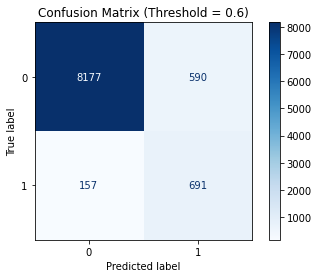

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_custom)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')  # You can change the colormap
plt.title(f"Confusion Matrix (Threshold = {custom_threshold})")
plt.grid(False)
plt.show()

In [18]:
print("Best cross-validated mean F1 score (minority class):", grid.best_score_)

Best cross-validated mean F1 score (minority class): 0.5814277031470637
